In [1]:
%load_ext jupyter_black
%matplotlib inline

In [2]:
import numpy as np
import torch as tc
import matplotlib.pyplot as plt

In [3]:
from torchvision.datasets import MNIST

train = MNIST("", download=True, train=True)
test = MNIST("", download=True, train=False)

In [4]:
X_train = train.data
y_train = train.targets
X_test = test.data
y_test = test.targets

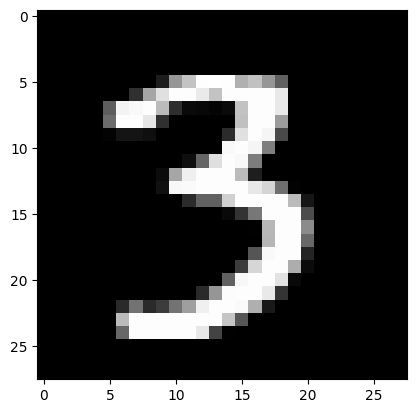

The number in the image is 3


In [5]:
image = X_train[10000]
label = y_train[10000]

plt.imshow(image, cmap="gray")
plt.show()
print("The number in the image is", label.numpy())

In [6]:
train_counts = tc.bincount(y_train).numpy()
test_counts = tc.bincount(y_test).numpy()

In [7]:
print("Training set counts:", train_counts)
print("Testing set counts:", test_counts)

Training set counts: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Testing set counts: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [8]:
print("Size of X_train is", X_train.numpy().shape)
print("Size of y_train is", y_train.numpy().shape)
print("Size of X_test is", X_test.numpy().shape)
print("Size of y_test is", y_test.numpy().shape)

Size of X_train is (60000, 28, 28)
Size of y_train is (60000,)
Size of X_test is (10000, 28, 28)
Size of y_test is (10000,)


In [9]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [10]:
print("Size of X_train is", X_train.numpy().shape)
print("Size of X_test is", X_test.numpy().shape)

Size of X_train is (60000, 1, 28, 28)
Size of X_test is (10000, 1, 28, 28)


In [11]:
X_train = X_train.float() / 255
X_test = X_test.float() / 255

In [12]:
mean = tc.mean(X_train, dim=(0, 2, 3))
std = tc.std(X_train, dim=(0, 2, 3))

In [13]:
print("Mean of X_train is", np.squeeze(mean.numpy()))
print("Standard deviation of X_train is", np.squeeze(std.numpy()))

Mean of X_train is 0.13066047
Standard deviation of X_train is 0.30810782


In [14]:
X_train = (X_train - mean[None, :, None, None]) / std[None, :, None, None]
X_test = (X_test - mean[None, :, None, None]) / std[None, :, None, None]

In [15]:
import torch.nn as nn
import torch.nn.init as init


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        init.xavier_normal_(self.conv1.weight)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        init.xavier_normal_(self.conv2.weight)

        self.fc3 = nn.Linear(400, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc3_dropout = nn.Dropout(0.2)
        init.xavier_normal_(self.fc3.weight)

        self.fc4 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc4_dropout = nn.Dropout(0.1)
        init.xavier_normal_(self.fc4.weight)

        self.fc5 = nn.Linear(84, 10)
        init.xavier_normal_(self.fc5.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = tc.tanh(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = tc.tanh(x)
        x = self.pool2(x)

        x = tc.flatten(x, 1)

        x = self.fc3(x)
        x = self.bn3(x)
        x = tc.tanh(x)
        x = self.fc3_dropout(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = tc.tanh(x)
        x = self.fc4_dropout(x)

        x = self.fc5(x)

        return x

In [16]:
import torch.optim as optim

model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=9e-3, weight_decay=3e-6)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [17]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

epochs = 5
losses = []
val_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_val_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()

    scheduler.step()

    epoch_loss /= len(train_dataset)
    losses.append(epoch_loss)

    model.eval()

    with tc.no_grad():
        for inputs, targets in test_loader:
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets)
            epoch_val_loss += val_loss.item() * inputs.size(0)

    epoch_val_loss /= len(test_dataset)
    val_losses.append(epoch_val_loss)

    model.train()

    print(
        f"Epoch: {epoch + 1}/{epochs}, Training Loss: {losses[epoch]:.4f}, Validation Loss: {val_losses[epoch]:.4f}"
    )

Epoch: 1/5, Training Loss: 0.1557, Validation Loss: 0.0973
Epoch: 2/5, Training Loss: 0.0567, Validation Loss: 0.0363
Epoch: 3/5, Training Loss: 0.0397, Validation Loss: 0.0297
Epoch: 4/5, Training Loss: 0.0306, Validation Loss: 0.0275
Epoch: 5/5, Training Loss: 0.0239, Validation Loss: 0.0232


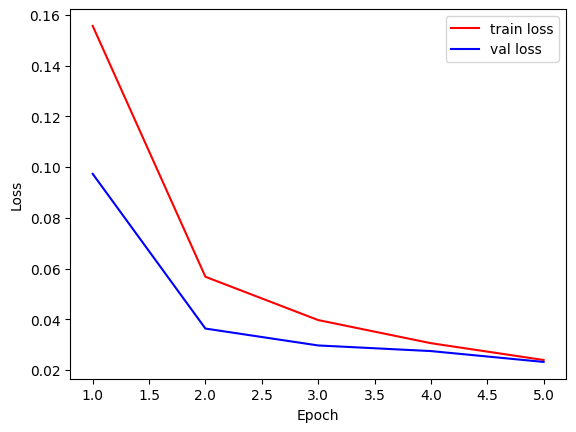

In [18]:
plt.plot(range(1, epochs + 1), losses, color="red", label="train loss")
plt.plot(range(1, epochs + 1), val_losses, color="blue", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
model.eval()

with tc.no_grad():
    train_pred = tc.argmax(model(X_train), dim=1)
    test_pred = tc.argmax(model(X_test), dim=1)

In [20]:
from sklearn.metrics import accuracy_score

print("Training accuracy score is", accuracy_score(y_train, train_pred))
print("Testing accuracy score is", accuracy_score(y_test, test_pred))

Training accuracy score is 0.9963166666666666
Testing accuracy score is 0.9927


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision score is", precision_score(y_test, test_pred, average="weighted"))
print("Recall score is", recall_score(y_test, test_pred, average="weighted"))
print("F1 score is", f1_score(y_test, test_pred, average="weighted"))

Precision score is 0.9927055674724554
Recall score is 0.9927
F1 score is 0.9926975134198665


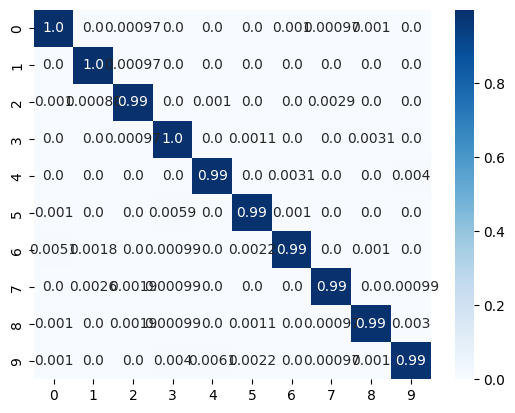

In [22]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test, test_pred)

sb.heatmap(cfm / np.sum(cfm, axis=1), annot=True, fmt=".2", cmap="Blues")
plt.show()

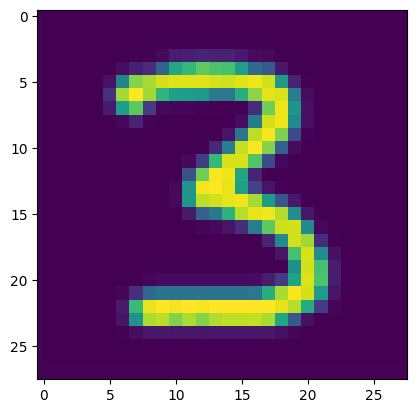

In [23]:
from PIL import Image

image = np.array(Image.open("number.png").resize((28, 28)).convert("L"))

plt.imshow(image)
plt.show()

In [24]:
print("Size of image is", image.shape)

Size of image is (28, 28)


In [25]:
image = tc.from_numpy(image).float()
image = image.unsqueeze(0).unsqueeze(0)

In [26]:
print("Size of image is", image.numpy().shape)

Size of image is (1, 1, 28, 28)


In [27]:
image = image / 255
image = (image - mean[None, :, None, None]) / std[None, :, None, None]

In [28]:
model.eval()

with tc.no_grad():
    prediction = tc.argmax(model(image), dim=1)

print("The model predicts the number", np.squeeze(prediction.numpy()), "in the image")

The model predicts the number 3 in the image


In [29]:
tc.save(model, "model.pth")